In [2]:
from bokeh.models import ColumnDataSource, CategoricalColorMapper, LegendItem, Legend, Slider, GroupFilter, CDSView
from bokeh.io import curdoc, show
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.themes import Theme

import pandas as pd
import numpy as np
import pacmap

# Data Processing

In [1]:
# Column names for the two parts
columns_part1 = ["chrom", "start_position", "end_position", "modified_base_code", "score", "strand", "start_position_compat", "end_position_compat", "color"]
columns_part2 = ["N_valid_cov", "fraction_modified", "N_mod", "N_canonical", "N_other_mod", "N_delete", "N_fail", "N_diff", "N_nocall"]

# Read the first part with '\t' delimiter
df_part1 = pd.read_csv("../public/Kasumi1-naive-p2solo.bed.gz", sep='\t', header=None, usecols=range(9), names=columns_part1)

# Read the second part with ' ' delimiter
df_part2 = pd.read_csv("../public/Kasumi1-naive-p2solo.bed.gz", delim_whitespace=True, header=None, usecols=range(9, 18), names=columns_part2)

# Concatenate the two dataframes horizontally
df = pd.concat([df_part1, df_part2], axis=1)

# Filter the dataframe by modified base code
df_5mc = df[df["modified_base_code"] == "m"]

# Load the list of suboptimal probes
zhou2016_probes = pd.read_csv('../public/EPIC.anno.GRCh38.tsv', sep='\t')

# Copy the df_5mc dataframe to avoid SettingWithCopyWarning
df_5mc_copy = df_5mc.copy()

# Add a column with the coordinate of the probe in the copied dataframe
df_5mc_copy['coordinate'] = df_5mc_copy['chrom'].astype(str) + ':' + df_5mc_copy['start_position'].astype(str)
zhou2016_probes['coordinate'] = zhou2016_probes['chrm'].astype(str) + ':' + zhou2016_probes['start'].astype(str)

# Merge the two dataframes
df_5mc_merged = pd.merge(df_5mc_copy, zhou2016_probes[['probeID','coordinate']], on='coordinate', how='inner')

# Set the index to the probeID
df_5mc_merged = df_5mc_merged.set_index('probeID')

# Create beta values column
df_5mc_merged['Kasumi1-naive'] = (df_5mc_merged['fraction_modified'] / 100).round(3)

# Create a new dataframe with only the beta values
df_nanopore = df_5mc_merged[['Kasumi1-naive']].T

# read df_discovery and df_validation
df_discovery = pd.read_pickle('../public/3308samples_333059cpgs_withbatchcorrection_bvalues.pkl.gz').sort_index()

# Load clinical data
discovery_clinical_data = pd.read_csv('../public/discovery_clinical_data.csv', index_col=0)

# Create a new dataframe to contain metadata for `df_nanopore`, which represents sample 'UF_hem_1832_PB'
validation_clinical_data = pd.DataFrame(index=df_nanopore.index)

# Adjust clinical data
discovery_clinical_data['Train Test'] = 'Discovery (train) Samples'
validation_clinical_data['Train Test'] = 'Kasumi1-naive'

discovery_clinical_data['PaCMAP Output'] = 'Patient Samples'
validation_clinical_data['PaCMAP Output'] = 'Patient Samples'

discovery_clinical_data['Batch'] = df_discovery['Batch']
validation_clinical_data['Batch'] = 'Nanopore'

# add the following columns to `validation_clinical_data`: 'Clinical Trial', 'Sample Type', 'Patient_ID', 'ELN AML 2022 Diagnosis', 'Hematopoietic Lineage'
validation_clinical_data['Clinical Trial'] = 'UF Hem Bank'
validation_clinical_data['Sample Type'] = 'Peripheral Blood'
validation_clinical_data['Patient_ID'] = 'Kasumi1-naive'
validation_clinical_data['ELN AML 2022 Diagnosis'] = np.nan
validation_clinical_data['Hematopoietic Lineage'] = np.nan

# use overlapping features between df_discovery and df_nanopore
common_features = [x for x in df_discovery.columns if x in df_nanopore.columns]

# apply `common_features` to both df_discovery and df_nanopore
df_discovery = df_discovery[common_features]
df_nanopore = df_nanopore[common_features]

print(
f' Discovery dataset (df_discovery) contains {df_discovery.shape[1]} \
columns (5mC nucleotides/probes) and {df_discovery.shape[0]} rows (samples).')

print(
f' Validation dataset (df_nanopore) contains {df_nanopore.shape[1]} \
columns (5mC nucleotides/probes) and {df_nanopore.shape[0]} rows (samples).')

# Save as pickle
df_discovery.to_pickle('../public/df_discovery.pkl.gz')
df_nanopore.to_pickle('../public/df_nanopore.pkl.gz')

/var/folders/3f/z26khc5x7_x83yw0bp96h9jc0000gn/T/ipykernel_25228/154912651.py:48: DtypeWarning: Columns (4,8,9,10,11,12,13,15,16,17,24,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,70,72,73,75,78,79,80,81,82,83,85,87,89,91,93,94,95,96,97,98,99,101,102,103,104,105,106,107,108,109,110,113,114,115,116,118,119,121,122,123,126,127,129,130,131,133,146,147,148,149,150,151,152,153,155,156,157,158,159,160,162,163,164,166,167,169,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,198,199,200,201,202,203,204,206,207,208,209,210,211,212,213,214,215,216,217,219,221,222,223,224,225,231,232,234,235,236,238,240,241,242,243,244,245,246,247,248,250,251,252,253,254,255,256,257,258,259,260,263,264,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318

 Discovery dataset (df_discovery) contains 331800 columns (5mC nucleotides/probes) and 3308 rows (samples).
 Validation dataset (df_nanopore) contains 331800 columns (5mC nucleotides/probes) and 1 rows (samples).


# Plotting

In [3]:
import matplotlib.pyplot as plt

reducer = pacmap.PaCMAP(n_components=2, n_neighbors=15, MN_ratio=0.4, FP_ratio=16.0, 
                    random_state=42, lr=0.1, num_iters=5000)

embedding_training = reducer.fit_transform(df_discovery.to_numpy(dtype='float16'))
embedding_validation = reducer.transform(df_nanopore.to_numpy(dtype='float16'), df_discovery.to_numpy(dtype='float16'))

# Plot embedding
plt.figure(figsize=(10, 10))
plt.scatter(embedding_training['PaCMAP 1'], embedding_training['PaCMAP 2'], c='green', s=5, alpha=0.5)
plt.scatter(embedding_validation[:, 0], embedding_validation[:, 1], c='black', s=50, alpha=1)
plt.xticks([])
plt.yticks([])

# Save the plot
plt.savefig('../public/results.png', dpi=300)

/Users/sckaff/Library/Python/3.9/lib/python/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


## Plot matplotlib

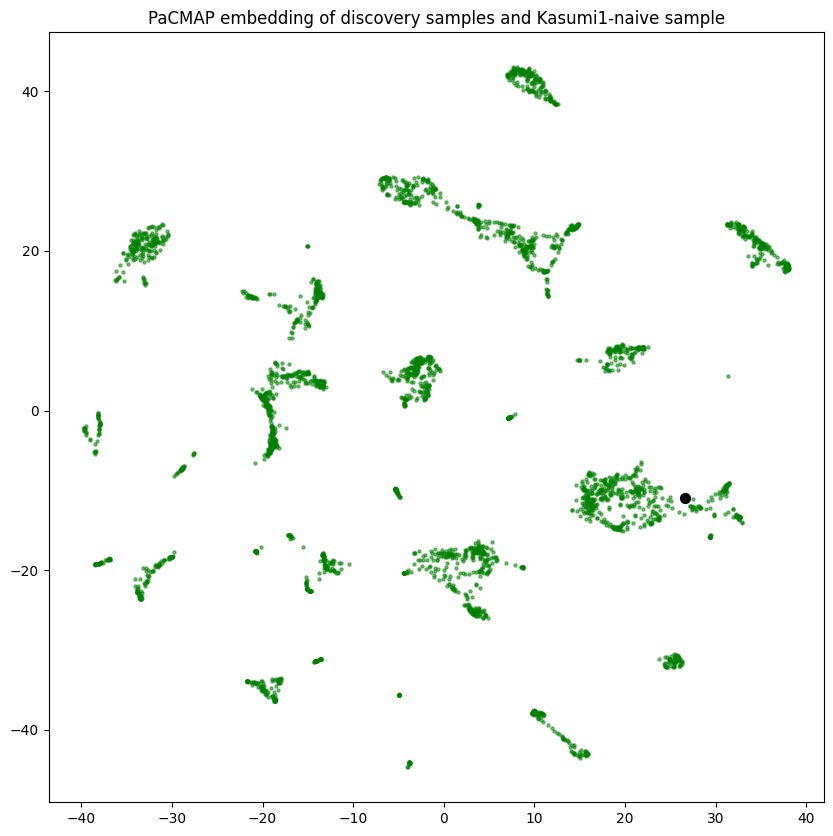

In [6]:
# Quickly plot the embedding


plt.figure(figsize=(10, 10))
plt.scatter(embedding_training[:, 0], embedding_training[:, 1], c='green', s=5, alpha=0.5)
plt.scatter(embedding_validation[:, 0], embedding_validation[:, 1], c='black', s=50, alpha=1)
plt.title('PaCMAP embedding of discovery samples and Kasumi1-naive sample')
plt.show()

# Temp

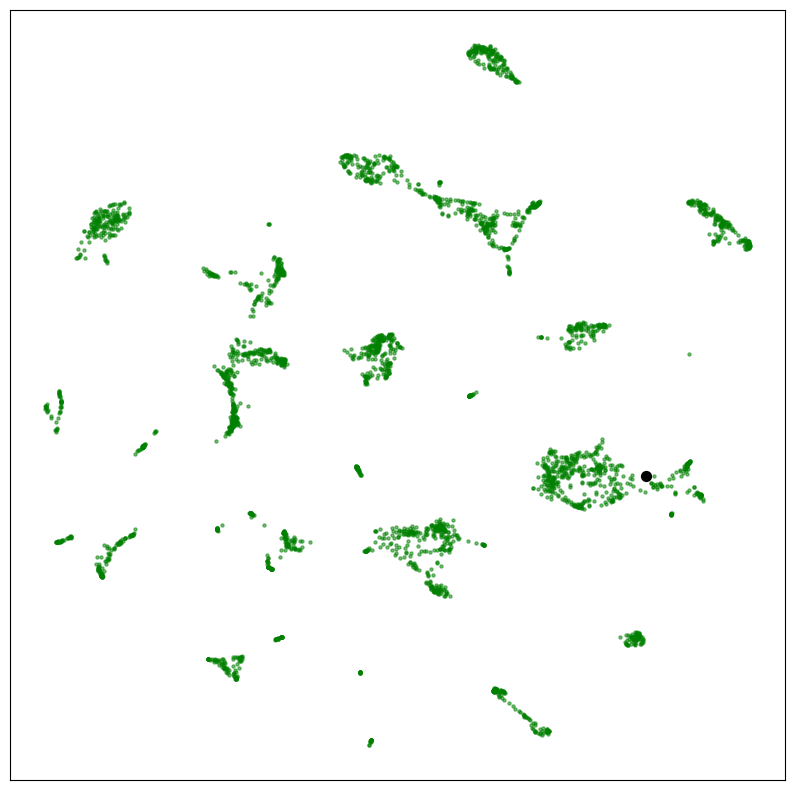

In [4]:
import pacmap
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Load the sample and training data
df_nanopore = pd.read_pickle('../public/df_nanopore.pkl.gz')
df_discovery = pd.read_pickle('../public/df_discovery.pkl.gz')

# Load the training after pacmap embedding to save time
embedding_training = pd.read_pickle('../public/pacmap_embedding.pickle')

# Load model
with open('../public/pacmap_model.pickle', 'rb') as f:
    reducer = pickle.load(f)

# Transform the validation data
embedding_validation = reducer.transform(df_nanopore.to_numpy(dtype='float16'), df_discovery.to_numpy(dtype='float16'))

# Plot embedding
plt.figure(figsize=(10, 10))
plt.scatter(embedding_training['PaCMAP 1'], embedding_training['PaCMAP 2'], c='green', s=5, alpha=0.5)
plt.scatter(embedding_validation[:, 0], embedding_validation[:, 1], c='black', s=50, alpha=1)
plt.xticks([])
plt.yticks([])
plt.show()

# Prognostic model
Calculating MethylScore

## Start by selecting the array-harmonized dataset

In [ ]:
import pandas as pd
from source.cox_lasso_functions import *

input_path = '../../Data/Intermediate_Files/'
output_path = '../../Data/Processed_Data/'

raw_coefs = pd.read_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs.csv', index_col=0)
mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.99)

df_validation = df_nanopore[mean_coefs.index]

print(
    f' Dataset (df) contains {df_validation.shape[1]} columns (5mC nucleotides/probes) and {df_validation.shape[0]} rows (samples).')

df_validation

 Dataset (df) contains 35 columns (5mC nucleotides/probes) and 1 rows (samples).


probeID,cg22855993,cg17099306,cg10089193,cg22162847,cg09890699,cg08329113,cg18072388,cg00920892,cg19706516,cg17669009,...,cg21637653,cg26223555,cg17632028,cg06748884,cg26846864,cg04839706,cg23875404,cg16424082,cg06339275,cg02918093
Kasumi1-naive,1.0,0.4,0.111,0.4,0.583,0.692,0.9,0.546,1.0,0.125,...,1.0,1.0,1.0,1.0,0.692,1.0,1.0,1.0,0.357,0.875


## Transform to M-values

In [ ]:
import math
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# change values of 1 to 0.999 and 0 to 0.001
df_validation_transformed = df_validation.replace(1, 0.999).replace(0, 0.001)
df_validation_transformed

def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_test_m = df_validation_transformed.apply(np.vectorize(beta2m))

## Standardize Data

In [ ]:
def standardize_data(df, reference_df):
    """Standardize data using mean and standard deviation of reference dataset"""

    # Keep only columns that are in both datasets
    reference_df = reference_df.loc[:, df.columns]

    # Standardize data
    df_z = (df - reference_df.mean()) / reference_df.std()

    return df_z

# Read top CpGs selected from previous code file (univariate cox-ph EWAS)
ewas_top_cpgs = pd.read_csv(output_path+'ewas_dmr/ewas_top_cpgs.csv', index_col=0)

# Standardize data
x_test_m_z = standardize_data(df= x_test_m, reference_df= ewas_top_cpgs)

## Generate model results

In [ ]:
score_name = 'MethylScoreAML_Px'

df_test, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=x_test_m_z,
                                        df=df_validation_transformed,
                                        score_name=score_name,
                                        train_test=0.2208,
                                        rpart_outcome='os.time')

df_validation_transformed[['MethylScoreAML_Px','MethylScoreAML_Px Categorical']]


Continuous score cut at the value of 0.2208


probeID,MethylScoreAML_Px,MethylScoreAML_Px Categorical
Kasumi1-naive,-1.084246,Low
